# **3. Data Analysis**
The main concepts that we have analyzed to better understand how to treat data have been:
1. Trend and Seasonality
2. Autocorrelation
3. Feature Correlation
4. Clustering

Here you can find a brief description of the previous topic and our arguments about them.

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys
sys.path.append("../")

csv_train = pd.read_csv("../dataset/original/train.csv")
csv_test = pd.read_csv("../dataset/original/x_test.csv")

from preprocessing.preprocessing import preprocessing, adjust_prep 
df = preprocessing(csv_train, csv_test)
df = df.sort_values(['Date'])
df_train = df[df.Date < '2019-06-29']
df_train = adjust_prep(df_train)

C:\Users\david\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## **3.1 Trend and Seasonality** 
We want to study the behaviour of the product in the scope. This because they are the ones that we want to predict and also to better visualize plots.

In [3]:
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)

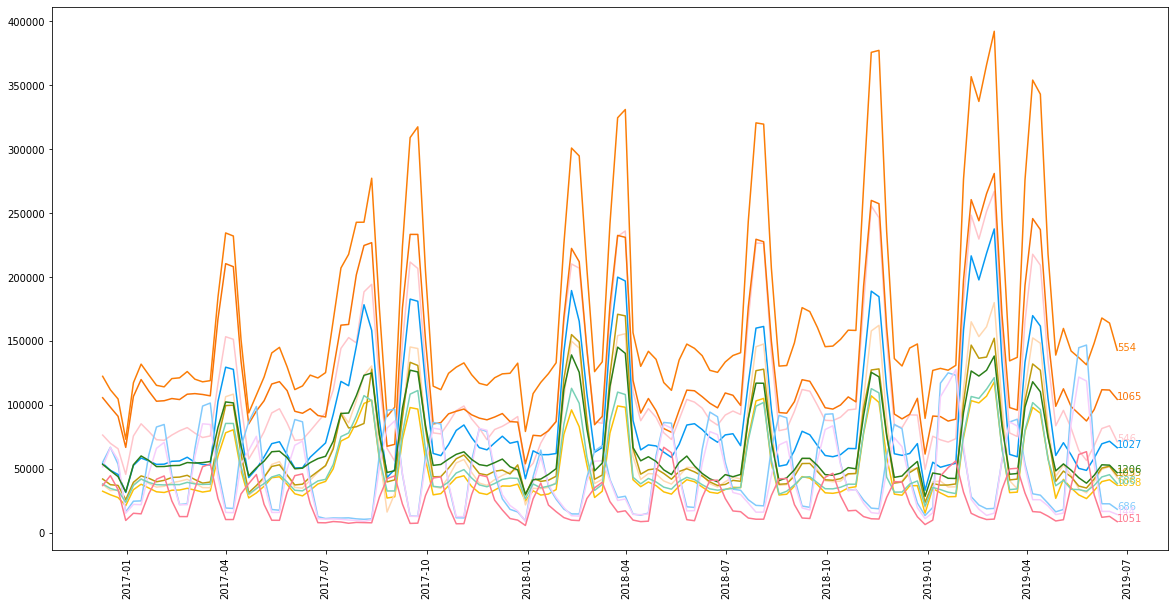

In [4]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
for i,s in enumerate(set(df[df.scope == 1].sku)):
    plt.plot(df_train[df_train.sku == s].Date, df_train[df_train.sku == s].real_target, color=mycolors[i])
    last_x, last_y = df_train[df_train.sku == s].Date.values[-1], df_train[df_train.sku == s].real_target.values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

From the previous plot seems that some time series have the same peaks and this could be related to the period of the year. We can also say that we don't find a specific trend, they just swing without an overall increment or decrement. <br>
So, it can be useful to study the seasonality and try to give a sense to common peaks.

Text(0, 0.5, 'Target')

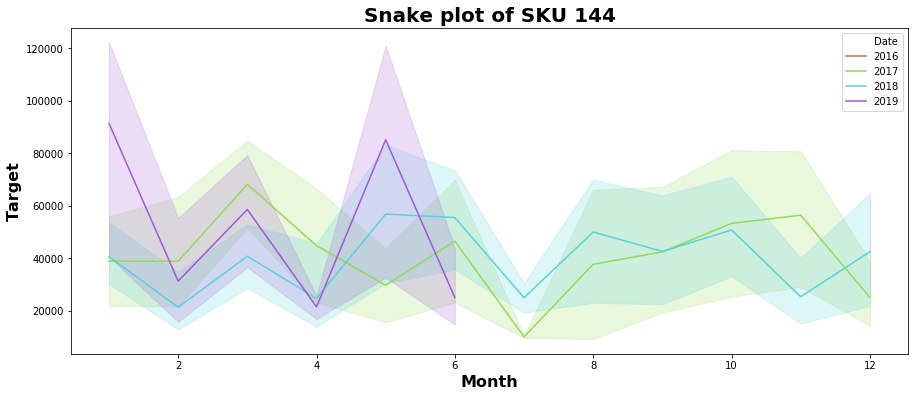

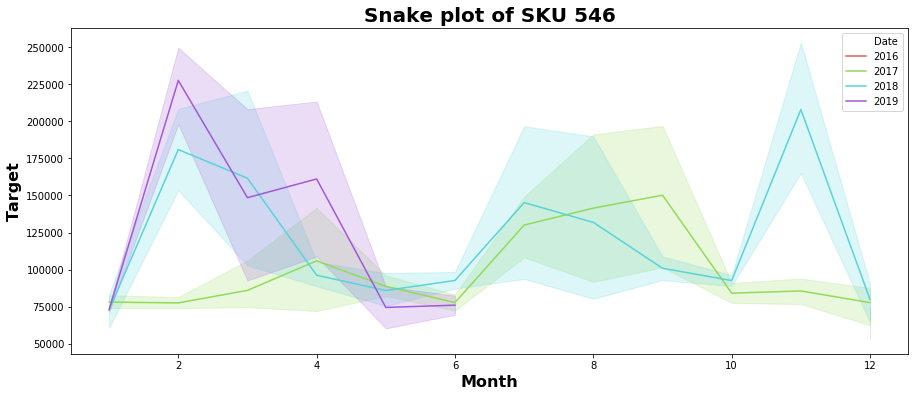

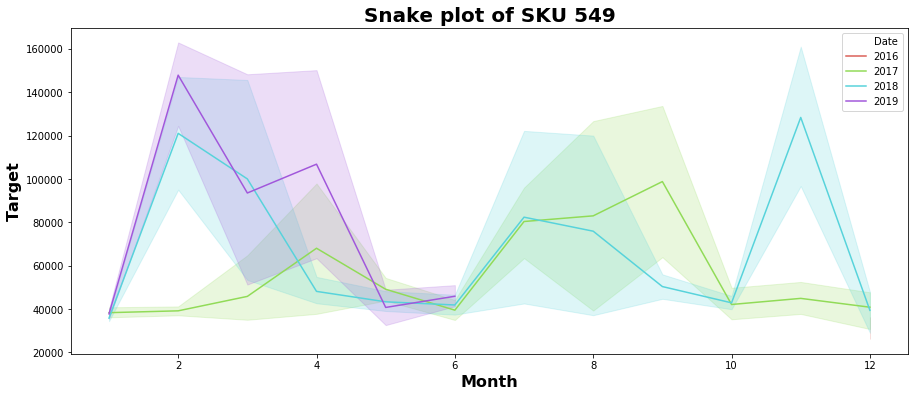

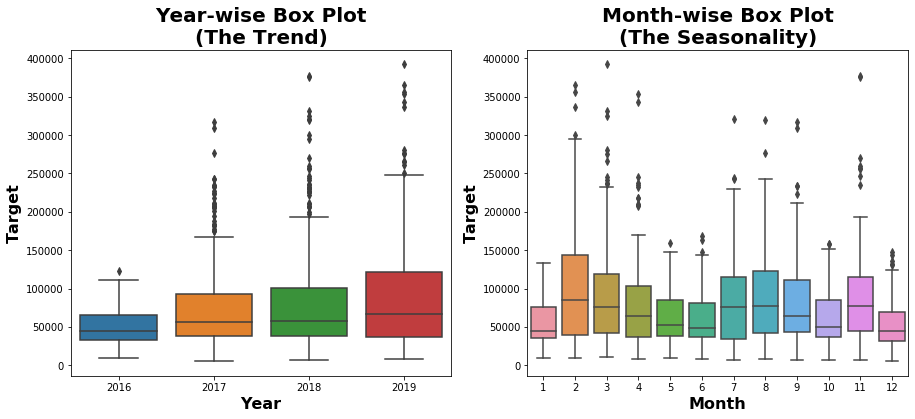

In [5]:
df_scope_train = df_train[df_train.scope == 1]

variable = 'real_target'
palette = sns.color_palette("hls", 4)

for s in sorted(set(df_scope_train.sku))[:3]:
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.lineplot(df_train[df_train.sku == s]['Date'].dt.month, df_train[df_train.sku == s][variable], hue=df_train[df_train.sku == s]['Date'].dt.year, palette=palette)
    ax.set_title('Snake plot of SKU ' + str(s), fontsize=20, loc='center', fontdict=dict(weight='bold'))
    ax.set_xlabel('Month', fontsize=16, fontdict=dict(weight='bold'))
    ax.set_ylabel('Target', fontsize=16, fontdict=dict(weight='bold'))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(df_scope_train['Date'].dt.year, df_scope_train[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Target', fontsize=16, fontdict=dict(weight='bold'))

sns.boxplot(df_scope_train['Date'].dt.month, df_scope_train[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize=16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Target', fontsize=16, fontdict=dict(weight='bold'))


Here we have plotted three snake plots taking the first three products ordering SKUs (actually we have plotted them also for each specific SKU, but we don't show it here). As we can see there is not a homogeneus similarity among the three years, in some months they are very similar, but in others they behaves in different ways, a hint that we cannot speak too much about seasonality. <br>
At the same time, we can find from the first box plot that there is not a clear trend in data and, even if it seems that could be a little seasonality in the second box plot, the snake plot assures us that this is not really true.   

Another way to confirm this is with ADFuller test, which says if a time series is stationary or not. If it is then it has no relevant seasonality and trend.

In [6]:
from statsmodels.tsa.stattools import adfuller

for sku in sorted(set(df_scope_train.sku)):
    adf = adfuller(df_scope_train[df_scope_train.sku == sku]['real_target'])
    print("p-value of " + str(sku) + " sales: %.4f" % adf[1])

p-value of 144 sales: 0.0000
p-value of 546 sales: 0.0001
p-value of 549 sales: 0.0053
p-value of 554 sales: 0.0069
p-value of 686 sales: 0.0051
p-value of 688 sales: 0.0001
p-value of 1027 sales: 0.0000
p-value of 1035 sales: 0.0056
p-value of 1051 sales: 0.0000
p-value of 1058 sales: 0.0001
p-value of 1065 sales: 0.0001
p-value of 1206 sales: 0.0001


As we can see above, we can reject with confidence of 95% the hypothesis that the time series in the scope are non-stationary.
This will be useful in the following notebooks when we will try to forescat with ARIMA. <br>
[ We don't show here series outside the scope because actually they won't be useful for next discussions, but we have found that some of them are non-stationary. ]

---
# **3.2 Autocorrelation**
Another important analysis that we need to discuss is autocorrelation within each time series. In fact, even if they have not a great seasonality, they still could be affected by previous steps, so it could be very informative to study their autocorrelation.

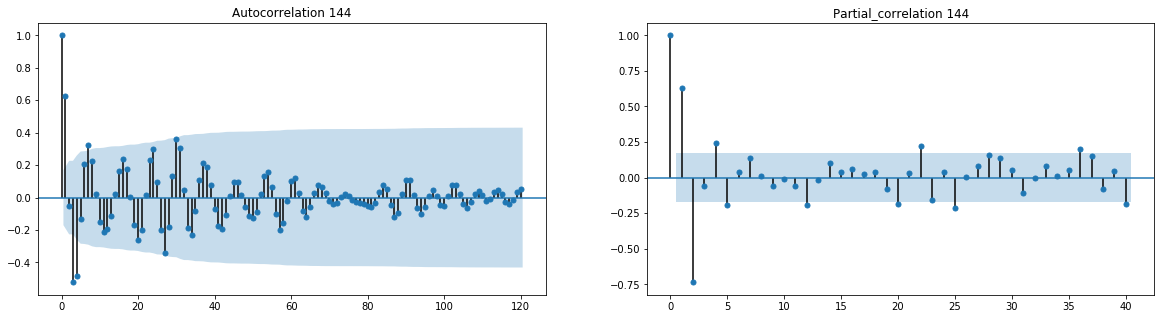

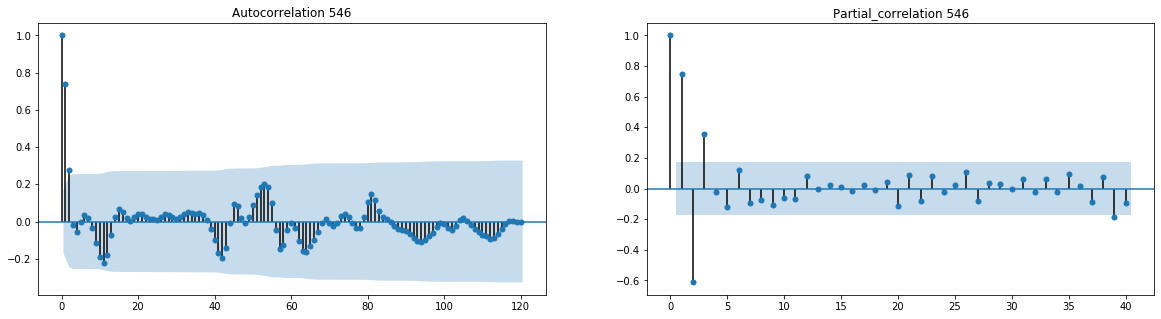

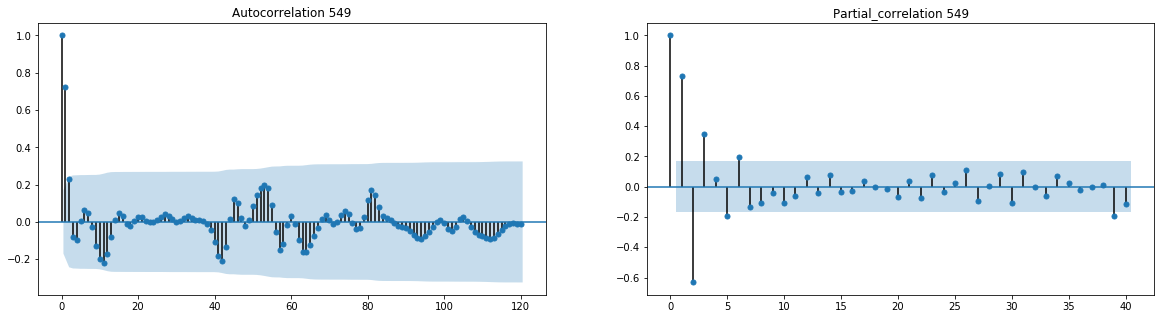

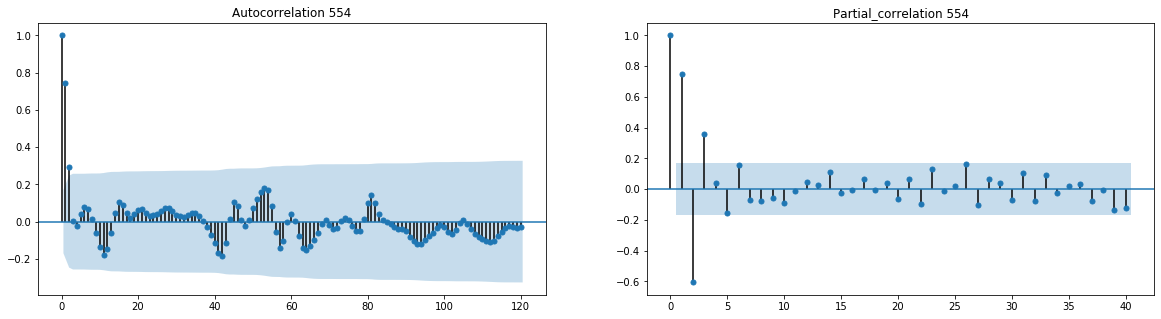

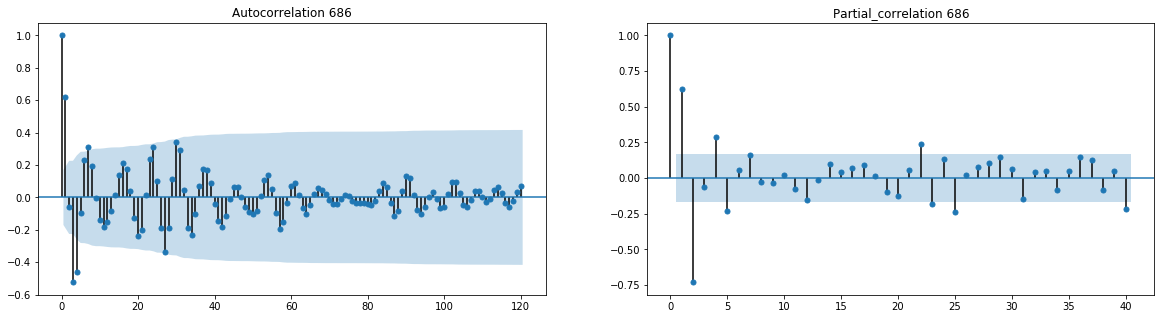

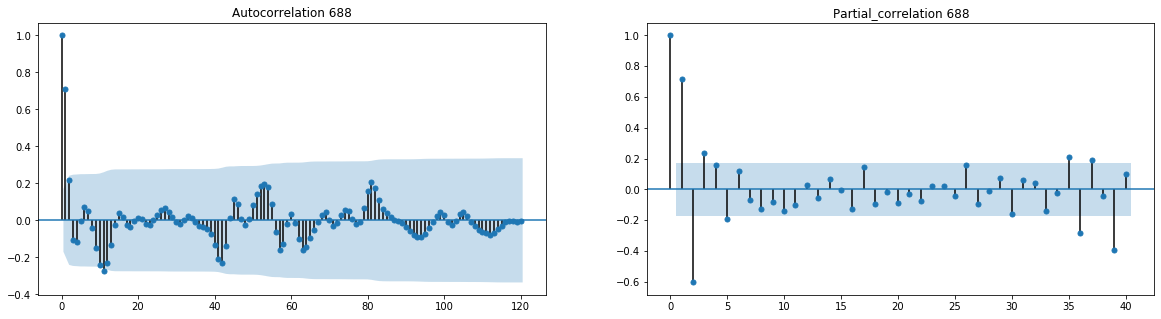

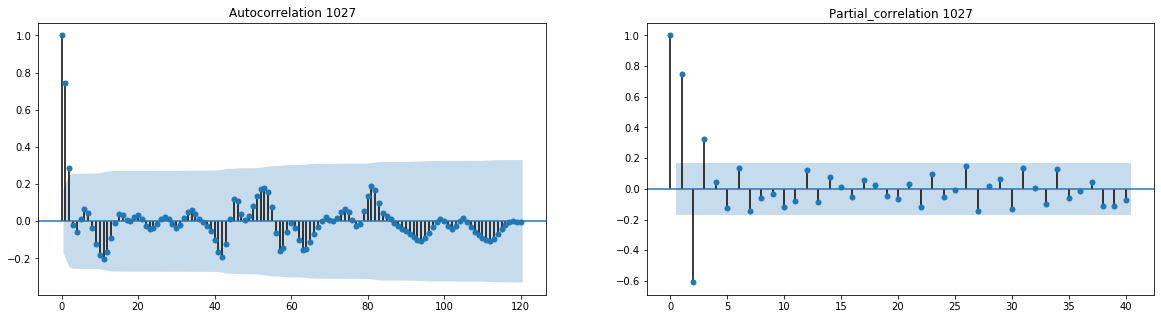

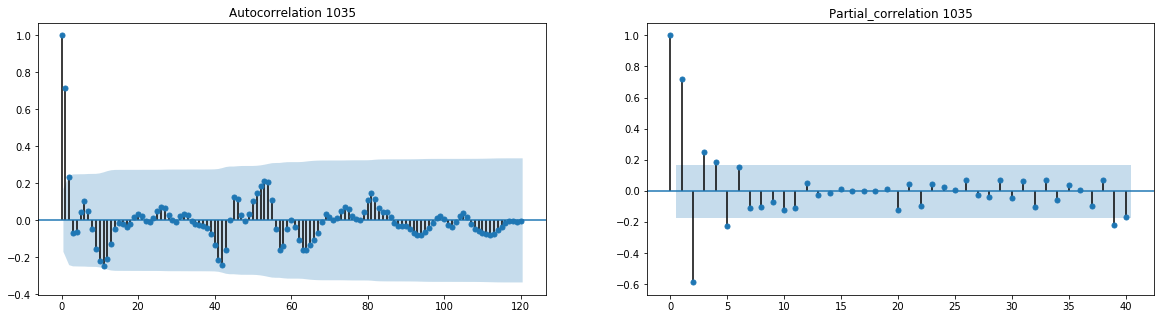

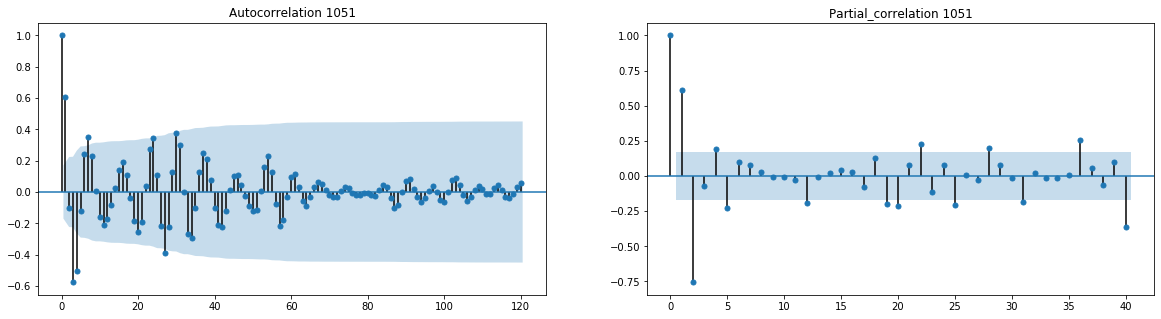

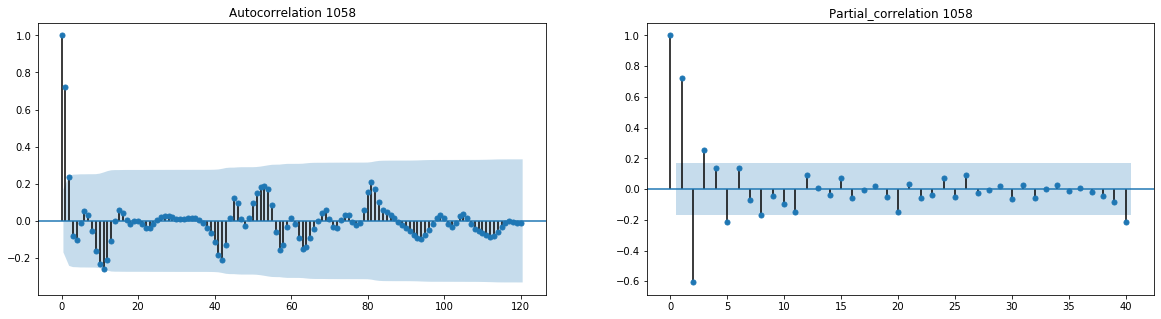

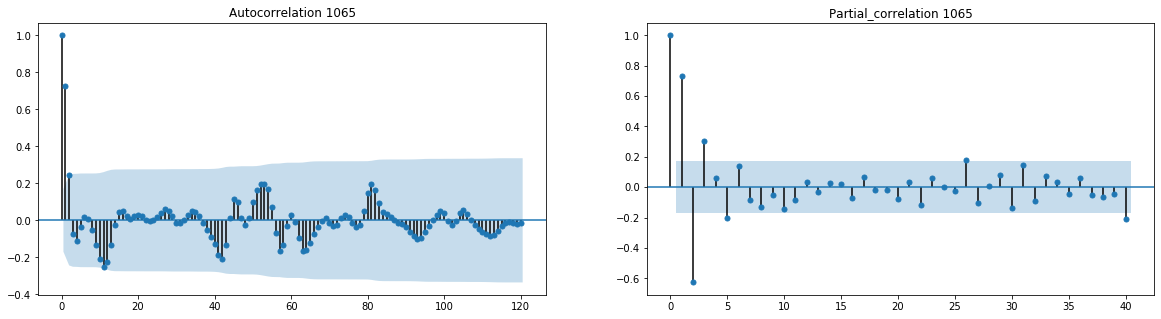

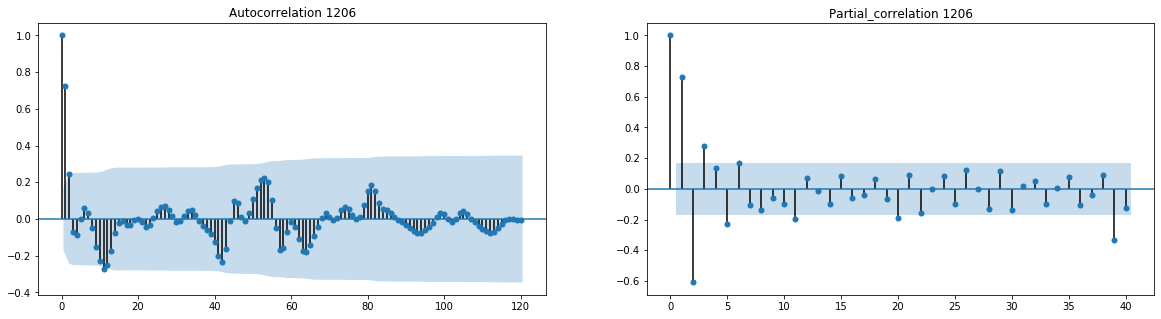

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for s in sorted(set(df_scope_train.sku)):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))    
    
    plot_acf(df_scope_train[df_scope_train.sku == s]['real_target'], ax=ax[0], lags=120, title="Autocorrelation " + str(s))
    plot_pacf(df_scope_train[df_scope_train.sku == s]['real_target'], ax=ax[1], lags=40, title="Partial_correlation " + str(s))

From the autocorrelation plot we can see that generally the time series are not very autocorrelated, excpet for some past steps around lag 50. We will exploit this observation to create some new features based on lag values. 

We have also studied the autocorrelation of other features like _price_, _POS_exposed w-1_ and _volume_on_promo w-1_ and also in those cases we have found the same results.

---
# **3.3 Feature Correlation**
Another analysis that we think important is the correlation between the different features of the dataset, also the ones that we can consider as side information. This has been very useful to create new features based on attributes which are dependent one to each other.

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(df_train[['price', 'real_target', 'sales w-1', 'pack', 'brand', 'size (GM)', 'POS_exposed w-1', 'volume_on_promo w-1']], height=3)

As we can see here we can notice that for example that the target (in this case <i> real _target</i>) so the sales and <i>price</i> are negatively correlated, so when the price is low the sales increase and viceversa.

---
# **3.4 Clustering**
In this section we perform clustering, more precisely the hierarchical clustering. The purpose is to group together the most correlated timeseries and to analyze their behaviour. <br>
The distance measure used for the clustering is the pair-wise _correlation_ of the time series. After the computation of the distance we plot the resulting dendrogram.

In [ ]:
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import stats

In [ ]:
series1 = []
ix = []

for i, s in enumerate(set(df_train.sku)):
    ix.append(s)
    series1.append(((df_train[df_train.sku == s]['real_target']).dropna().values))

series1 = np.asarray(series1)
z1 = linkage(series1, 'single', metric='correlation')

In [ ]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(z1, leaf_rotation=90., leaf_font_size=8., labels=ix)
plt.show()

Since the resulting dendogram doesn't help us too much to understand the best cut level and so the best number of clusters, we use the **_Knee & Elbow_ analysis**. <br>
So in the following section of code we compute the WSS and the BSS to see respectively how the time series are closely related in the cluster and how well clusters are separated one from the others.

In [ ]:
wss_values = []
bss_values = []
k_values = range(1,20)

for k in k_values:
    clustering = fcluster(z1, k, criterion='maxclust')
    centroids = [np.mean(series1[clustering ==c], axis=0) for c in range(1, k+1)]
    cdist(series1, centroids, 'correlation')
    D = cdist(series1, centroids,'correlation')

    d = np.min(D,axis=1)

    avgWithinSS = sum(d)/series1.shape[0]

    # Total with-in sum of square
    wss = sum(d**2)

    tss = sum(pdist(series1, metric='correlation')**2) / series1.shape[0]
    
    bss = tss - wss
    
    wss_values += [wss]
    bss_values += [bss]

In [ ]:
fig = plt.figure(figsize=(20, 10))
font = {'family' : 'sans', 'size'   : 20}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.title("Knee & Elbow Analysis on Hierarchical Clustering")
plt.legend()

We plot the result and we can see that at 4 there is a drop in the plot.
There is an evident elbow at 4 so we put our evidence on what happens with 4 clusters. <br>
Using the _fcluster_ function we found the labels of the 4 clusters and we retrieve the corresponding sku, creating a small dataframe.

In [ ]:
label_corr = fcluster(z1, 4, criterion='maxclust') #Cluster with "correlation distance measure"
sku = list((set(df_train.sku)))

data={'Label':label_corr, 'Sku':sku}
df_cluster=pd.DataFrame(data, columns=['Label','Sku'])

In [ ]:
#1st cluster
cluster1=df_cluster[df_cluster.Label==1].Sku
cluster1=np.asarray(cluster1)

#2nd cluster
cluster2=df_cluster[df_cluster.Label==2].Sku
cluster2=np.asarray(cluster2)

#3rd cluster
cluster3=df_cluster[df_cluster.Label==3].Sku
cluster3=np.asarray(cluster3)

#4th cluster
cluster4=df_cluster[df_cluster.Label==4].Sku
cluster4=np.asarray(cluster4)

cluster=[cluster1,cluster2,cluster3,cluster4]

In [ ]:
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)

In [ ]:
fig = plt.figure(figsize=(25,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for n,j in enumerate(cluster):
    ax = fig.add_subplot(2, 2, n+1)
    plt.xticks(rotation=90)
    
    for i in range(len(j)):
        ax.plot(df_train[df_train.sku == j[i]].Date, df_train[df_train.sku == j[i]]['real_target'],  color=mycolors[i])
        last_x, last_y = df_train[df_train.sku == j[i]].Date.values[-1], df_train[df_train.sku == j[i]]['real_target'].values[-1]
        plt.text(last_x, last_y, str(j[i]), color=mycolors[i])

We can notice that the last cluster is composed only by one element, so it might be labeled as outlier. 

In the end, we plot the **Correlation Heatmap** for the first two clusters, which contain the products that we have to predict and we show that the time series inside them are highly correlated.

In [ ]:
di = {}

for i in cluster1:
    di.update({i:np.asarray((df_train[df_train.sku == i].real_target))})
df_clu1 = pd.DataFrame(di).pct_change().dropna()

corr1 = df_clu1.corr()
sns.set(font_scale=1.5)
sns.clustermap(corr1, cmap="Blues", annot=True);

di2 = {}
for i in cluster2:
    di2.update({i:np.asarray((df_train[df_train.sku == i].real_target))})
df_clu2 = pd.DataFrame(di2).pct_change().dropna()

corr2 = df_clu2.corr()
sns.set(font_scale=1.5)
sns.clustermap(corr2, cmap="Blues", annot=True);

The correlation heatmap of the third and fourth cluster are not showed, because the fourth cluster is composed only by one element and the third contains too much timeseries, so it would result in a very big heatmap and it wouldn't be well visualized.